# Likelihood fits with variable resolution

Let's take two samples Gaussian distributed
- Sample 1 with $\mu=1, \sigma=2$
- Sample 2 with $\mu=0, \sigma=1$.

Suppose one wants to extract the fraction $f$ events belongig to Sample 1.
The compund p.d.f. is

$$
pdf(x)=fG(x,1,2)+(1-f)G(x,0,1)
$$

Let's generate these samples and plot the distributions.

In [1]:
try:
  import google.colab
  IN_COLAB = True
except:
  IN_COLAB = False
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
#if IN_COLAB:
#    !pip install zfit
import math
from pylab import figure, cm
from scipy import integrate, stats

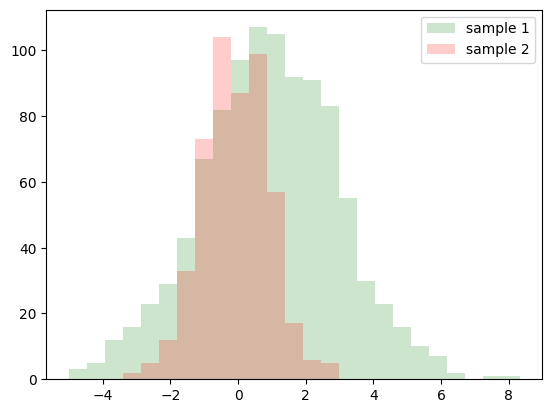

In [2]:
sample_1   = stats.norm.rvs(size = 500, loc = 0, scale = 1)
sample_2   = stats.norm.rvs(size = 1000, loc = 1, scale = 2)
sample = np.concatenate((sample_1, sample_2))
fig, ax = plt.subplots(1, 1)
_, bins, _ = ax.hist(sample_2, bins=25, alpha=0.2, color='green', label='sample 1')
ax.hist(sample_1, bins=bins, alpha=0.2, color='red', label='sample 2')
plt.legend()
plt.show()

As one want to estimate $f$ via Maximum-Likelhood estimation, let's write down the likelihood

$$
\mathcal{L}(f; x) = \prod_{i=1}^{N} fG(x_i,1,\sigma_i)+(1-f)G(x_,0,\sigma_i).
$$

This likelihood seems reasonable as the variance change event by event depending on the sample belonging to (in a more general case the variance could vary event by event within the same sample).

We can search for $\hat{f}_{MLE}$ and immediately recongnise that something is not working.

With a simulated $f=1/3$ it is found that the estimator is not consistent, and biased.

The first property contradicts the property of MLE being consistent.

In fact, the problem has two observables ($x_i, \sigma_i$), then the Likelihood mst be written

$$
\mathcal{L}(f; x) = \prod_{i=1}^{N} fp(x_i,\sigma_i|Sample1)+(1-f)p(x_,\sigma_i|Sample2)
$$

and remebering $p(x_i,\sigma_i|X)=p(x_i|\sigma_i,X)p(\sigma_i|X)$, then

$$
\mathcal{L}(f; x) = \prod_{i=1}^{N} fG(x_i,1,\sigma_i)p(\sigma_i|Sample1)+(1-f)G(x_,0,\sigma_i)p(\sigma_i|Sample2).
$$

With this correct Likelihood the consistency of the MLE is recovered.

We perform 150 pesudo experiment, with 150 events each and verify whatsaid above.

In [3]:
ZFIT_DISABLE_TF_WARNINGS=1
import zfit
zfit.settings.changed_warnings.all = False

obs = zfit.Space('x', (-10, 10))
gauss1 = zfit.pdf.Gauss(0, 1, obs)
gauss2 = zfit.pdf.Gauss(1, 2, obs)
frac = zfit.Parameter('fract', 0.5, 0, 1, step_size=0.02)
full_pdf = zfit.pdf.SumPDF([gauss1, gauss2], frac, obs)

/Users/frater/.pyenv/versions/3.10.2/lib/python3.10/site-packages/zfit/__init__.py:63: UserWarning: TensorFlow warnings are by default suppressed by zfit. In order to show them, set the environment variable ZFIT_DISABLE_TF_WARNINGS=0. In order to suppress the TensorFlow warnings AND this warning, set ZFIT_DISABLE_TF_WARNINGS=1.
  warnings.warn(
/Users/frater/.pyenv/versions/3.10.2/lib/python3.10/site-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


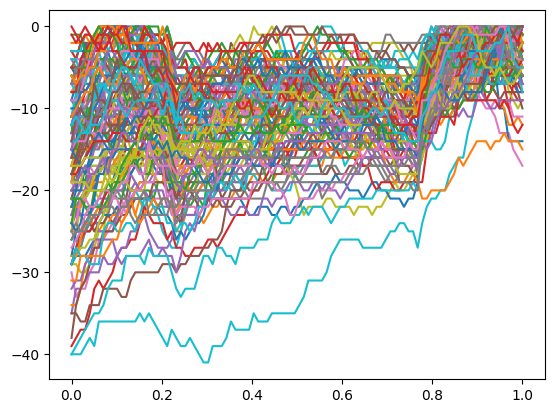

In [25]:
fraction=[]
fraction_wrong=[]
frac_space = np.linspace(0,1,100)
for n in range(150):
    logLL_wrong = np.full(100, 0)
    sample_1   = stats.norm.rvs(size = 50, loc = 0, scale = 1)
    sigma_1 = np.full(50, 1)
    sample_2   = stats.norm.rvs(size = 100, loc = 1, scale = 2)
    sigma_2 = np.full(100, 2)
    sample = np.concatenate((sample_1, sample_2))
    sigma = np.concatenate((sigma_1, sigma_2))
    for i in range(100):
        for s in range(150):
            logLL_wrong[i] +=  np.log(frac_space[i]*stats.norm.pdf(sample[s], scale=sigma[s]) + (1-frac_space[i])*stats.norm.pdf(sample[s], loc=1, scale=sigma[s]))
    LLmax = max(logLL_wrong)
    logLL_wrong = logLL_wrong - LLmax
    fpos = np.where(logLL_wrong == 0)
    fraction_wrong.append(frac_space[fpos][-1])
    plt.plot(frac_space, logLL_wrong)
    array_np = np.array(sample)
    data = zfit.Data.from_numpy(obs=obs, array=array_np)
    nll_expo = zfit.loss.UnbinnedNLL(full_pdf, data)
    minimizer = zfit.minimize.Minuit()
    result = minimizer.minimize(nll_expo)
    result.errors(method='minuit_minos')
    fraction.append(result.params[frac]['value'])

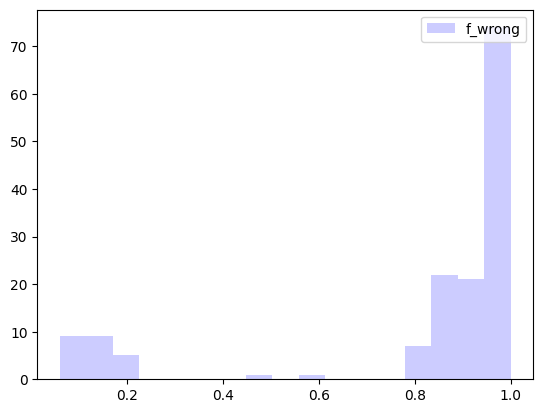

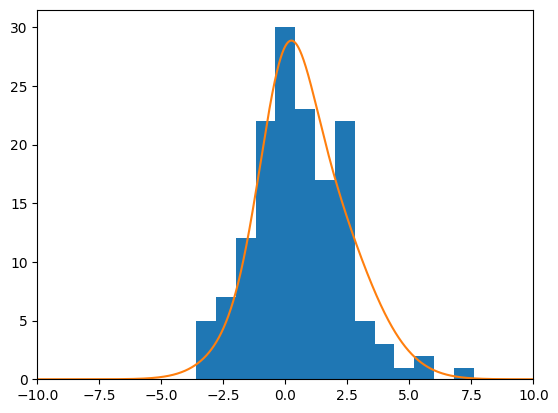

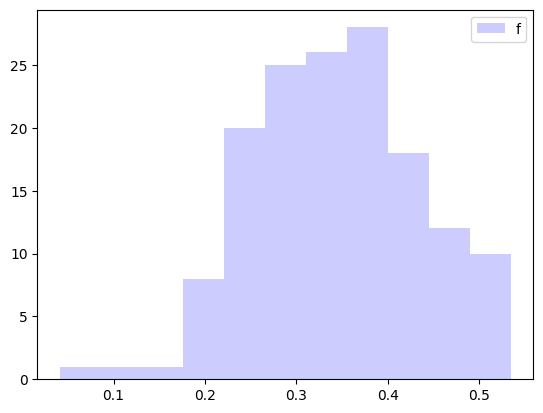

In [27]:
fig_wr, ax_wr = plt.subplots(1, 1)
ax_wr.hist(fraction_wrong[:-1], bins='auto', alpha=0.2, color='blue', label= 'f_wrong')
plt.legend(loc='upper right')
plt.show()

lam = np.linspace(-10,10,10000)
y = full_pdf.pdf(lam) * 150 / 25 * data.data_range.area()
data_plot = data.value()[:, 0] 
plt.hist(data_plot, bins=25, range=(-10,10))
plt.xlim([-10, 10])
plt.plot(lam, y)

fig, ax = plt.subplots(1, 1)
ax.hist(fraction, bins='auto', alpha=0.2, color='blue', label= 'f')
plt.legend(loc='upper right')
plt.show()

The reason for this rather spectacular failure
is that the second piece of $\mathcal{L}$, related to Sample1 events,
gets confused by the presence of the events of Sample2
with meaningless values of sigma, and viceversa: they unavoidably
enter both terms of $\mathcal{L}$ during the calculation.

When variable variable resolution enters the dataset and given two (or more) classes A and B one has $p(\sigma_i|A)\neq p(\sigma_i|B)$, then the full likelihood must be taken in account taking care of the distribution of $\sigma$ itself within the classes.

## References
[1] G. Punzi, Comments on Likelihood Fits with Variable Resolution, PHYSTAT2003, SLAC, Stanford, California, September 8-11, 2003